## Initial Setup

In [1]:
#!pip install rembg
#!pip install onnxruntime # required for rembg
#!pip install tensorflow-hub

In [2]:
# import dependencies
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from utils import remove_background, detect_and_crop, crop_to_square, expand_to_square
from PIL import Image
from rembg import remove
import numpy as np
import pandas as pd
import io
import tensorflow_hub as hub

# display paratmeters for matplotlib
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Initial Setup

In [3]:
# Load the pretrained model for image classification
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Load a pre-trained SSD model from TensorFlow Hub for object detection
# used in the detect_and_crop function
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

### Image Pre-processing Functions



In [4]:
# ################################################################################
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224), method=tf.image.ResizeMethod.AREA)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# ################################################################################
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# ################################################################################
# functions for manipulating image tensors available in the utils.py file

# def remove_background(image, background_color=(255, 255, 255)):

# # Helper function to identify the image subject and crop to a square bounding box
# def detect_and_crop(image):

# # Helper function to crop the image to a square
# def crop_to_square(image):

# # Helper function to add white space to the image that makes it square
# def expand_to_square(image, background_color=(255, 255, 255)):

## Original image


In [5]:
# Set the image path to a local file
image_path = "images/biscuit.jpg"  # Replace with the actual path to your image

# Read the image file
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# Remove background and preprocess the image
# image = remove_background(image)
# RESULTS- removing background appears to cause overfitting in the model

# Detect and crop to the primary object in the image
#image = detect_and_crop(image)
# RESULTS- this function works well for most images, but not all

# The optimal image cropping method is dependent on the image content and must be manually adjusted
# Crop image to square based on shortest side
image = crop_to_square(image)  # Crop to a square bounding box

# Pad the image boundaries to make it square based on longest side
#image = expand_to_square(image)  # Expand to a square with whitespace

# Preprocess the image
image = preprocess(image)

# Predict using the pretrained model
image_probs = pretrained_model.predict(image)

# Get the numeric index of the predicted class (0–999)
imagenet_index = tf.argmax(image_probs[0]).numpy()  # retrieve the predicted image index for the attack

# Decode the predictions to get the class label and confidence
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(image_probs, top=1)
top_prediction = decoded_predictions[0][0]  # Get the top prediction

# Extract the label and confidence
label = top_prediction[1]  # Class label
confidence = top_prediction[2]  # Confidence score

# Output the results
print(f"ImageNet Index: {imagenet_index}")
print(f"Class Label: {label}")
print(f"Confidence: {confidence * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
ImageNet Index: 285
Class Label: Egyptian_cat
Confidence: 31.91%


### Review the Image


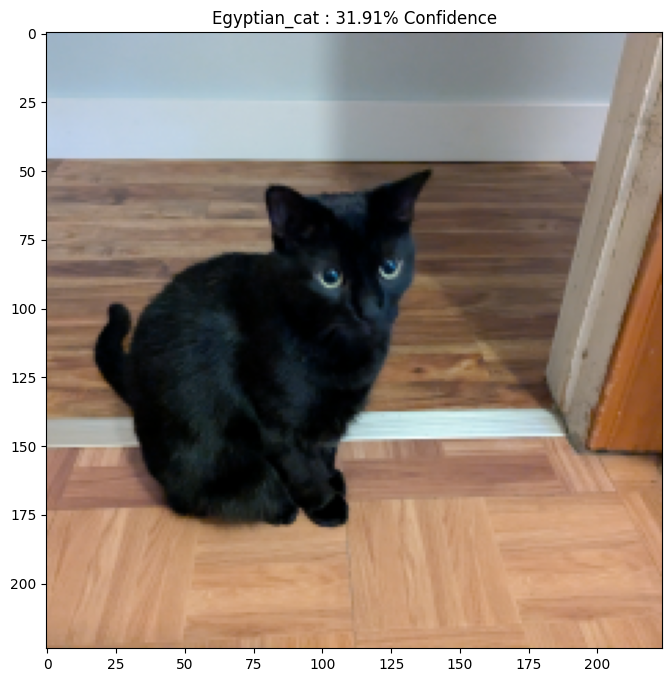

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1] for mpl display
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

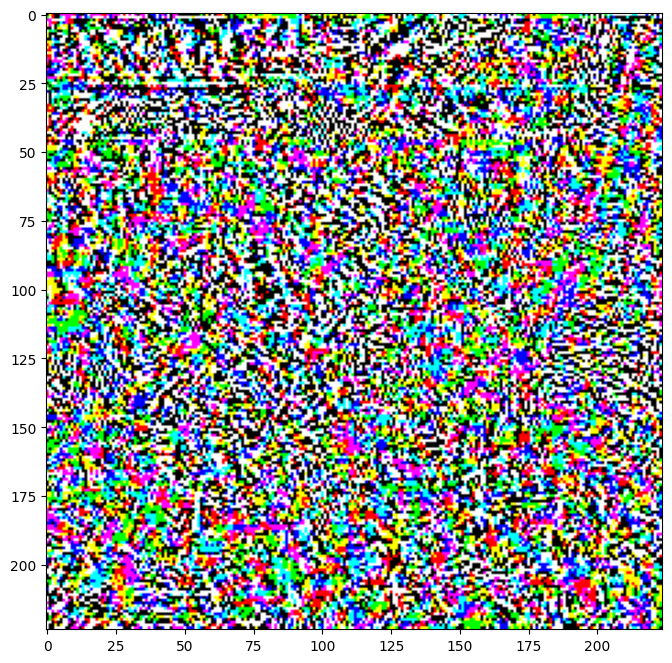

In [8]:
# Visualize the perturbations
# Get the input label of the image.
image_index = imagenet_index # Needs to be the index of the class you want to attack
label = tf.one_hot(image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To normalize [-1, 1] to [0,1]

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  #plt.title('{} \n {} | {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.title('{} \n {}'.format(description, label))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


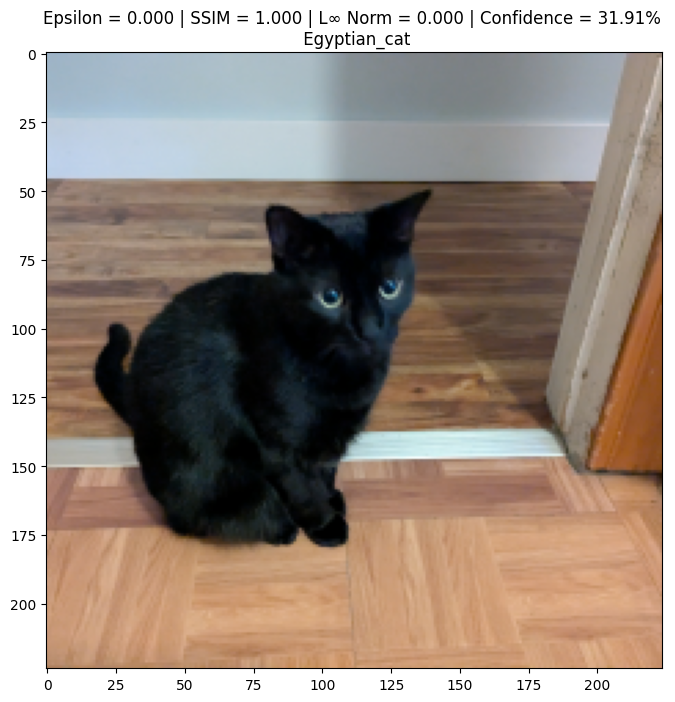

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


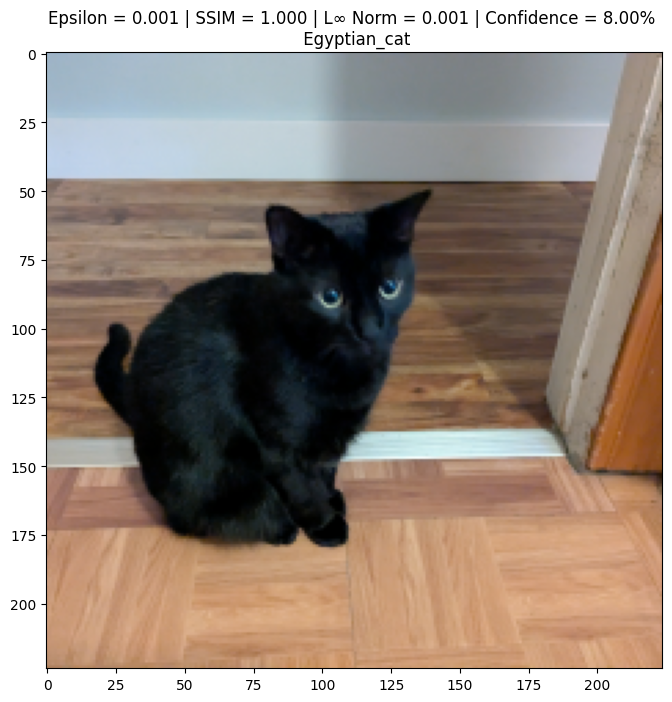

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


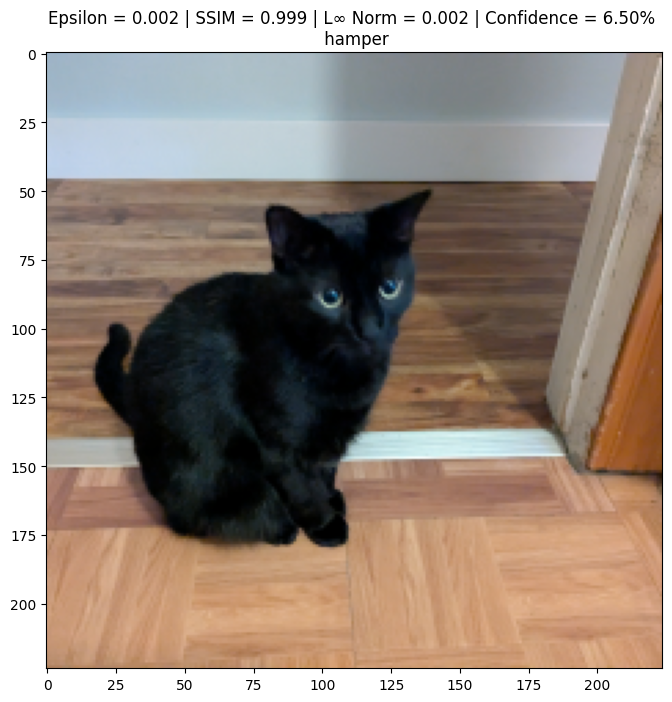

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


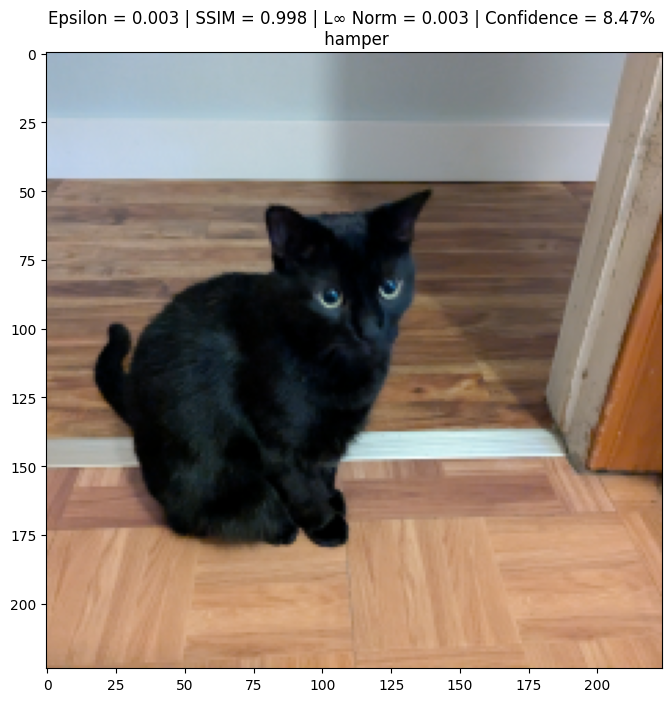

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


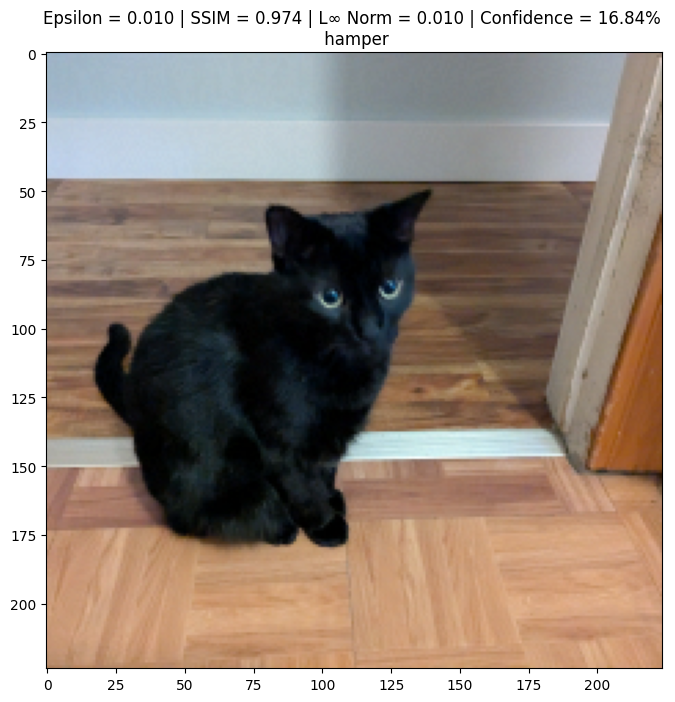

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


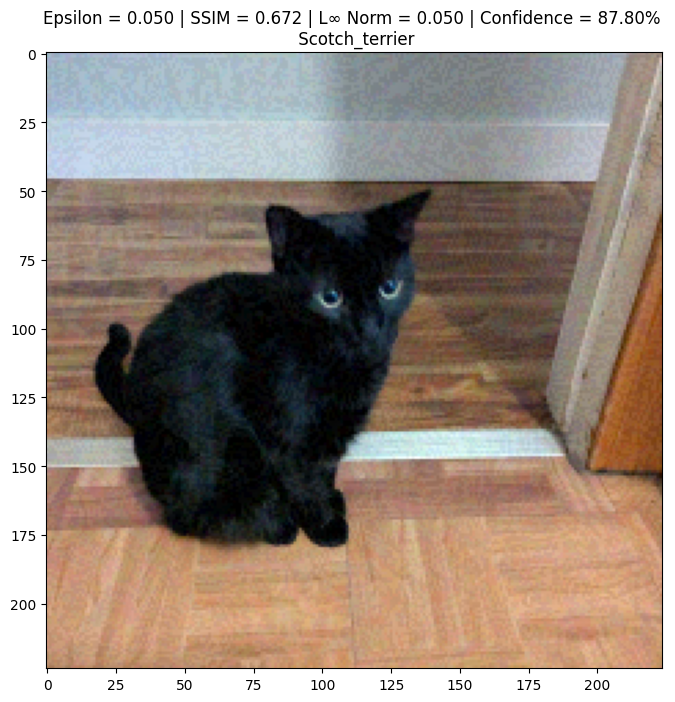

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


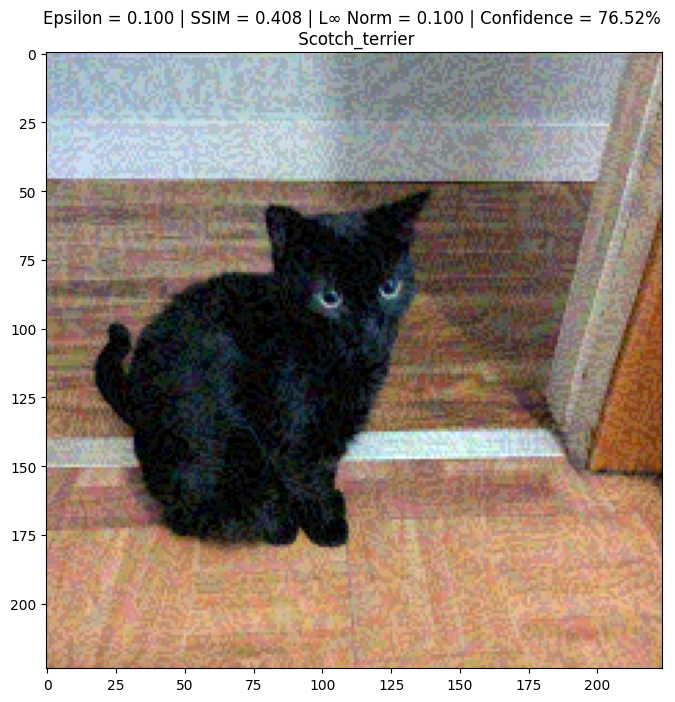

   Epsilon      SSIM  L∞ Norm  Confidence  Classification
0    0.000  1.000000    0.000   31.913094    Egyptian_cat
1    0.001  0.999862    0.001    7.996272    Egyptian_cat
2    0.002  0.999139    0.002    6.499498          hamper
3    0.003  0.997639    0.003    8.467145          hamper
4    0.010  0.973861    0.010   16.836121          hamper
5    0.050  0.672338    0.050   87.800598  Scotch_terrier
6    0.100  0.407627    0.100   76.517258  Scotch_terrier


In [10]:
original_image = image[0]  # Original image tensor for SSIM calculation

# Define epsilon values
epsilons = [0, 0.001, 0.002, 0.003, 0.01, 0.05, 0.1]

# Initialize a list to store the results
results = []

# Loop through each epsilon value
for i, eps in enumerate(epsilons):
    # Generate adversarial image
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    # Compute SSIM between the original and adversarial images
    ssim_value = tf.image.ssim(original_image, adv_x[0], max_val=1.0)
    ssim_mean = tf.reduce_mean(ssim_value).numpy()  # Average SSIM value

    # Compute L∞ Norm (maximum absolute perturbation)
    linf_norm = tf.reduce_max(tf.abs(original_image - adv_x[0])).numpy()

    # Get the classification label and confidence
    probs = pretrained_model.predict(adv_x)
    _, label, confidence = get_imagenet_label(probs)

    # Append the results to the list
    results.append({
        "Epsilon": eps,
        "SSIM": ssim_mean,
        "L∞ Norm": linf_norm,
        "Confidence": confidence * 100,  # Convert to percentage
        "Classification": label
    })

    # Add SSIM and L∞ Norm to the description
    description = f"Epsilon = {eps:.3f} | SSIM = {ssim_mean:.3f} | L∞ Norm = {linf_norm:.3f} | Confidence = {confidence * 100:.2f}%"

    # Display the adversarial image with the description
    display_images(adv_x, description)

# Convert the results to a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file for further analysis
df_results.to_csv("adversarial_results_with_linf.csv", index=False)

# Print the DataFrame to verify
print(df_results)

### Analyze the results

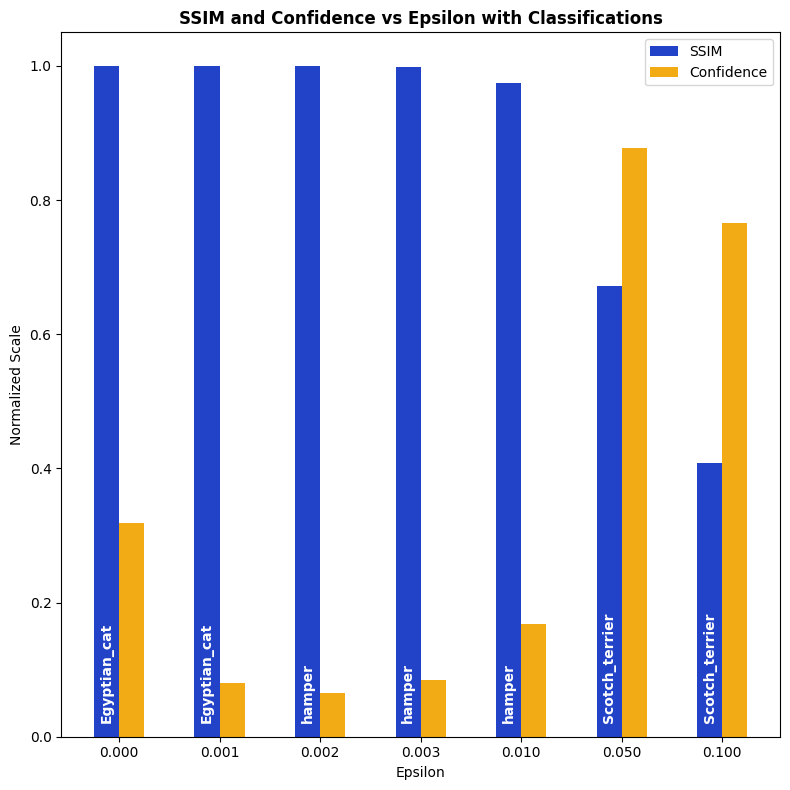

In [11]:
# Extract data from the DataFrame
epsilons = df_results['Epsilon']
ssim_values = df_results['SSIM']
linf_norms = df_results['L∞ Norm']
confidence_values = df_results['Confidence']
classifications = df_results['Classification']  # Extract classification labels

# Define the x-axis positions for the groups
x = np.arange(len(epsilons))  # Positions for the categories
width = 0.25  # Width of the bars

# Create the bar plots
plt.bar(x - width/2, ssim_values, width, label='SSIM', color='#2242c7')  # SSIM values
plt.bar(x + width/2, (confidence_values / 100), width, label='Confidence', color='#f2ab15')  # Confidence values

for i in range(len(epsilons)):
# Place the classification text inside the SSIM bar
    plt.text(
        x[i] - width/2,  # x position
        0.02,  # y position (just above the x-axis, adjust as needed)
        classifications[i],  # text
        ha='center',  # horizontal alignment
        va='bottom',  # vertical alignment
        fontweight='bold',  # make text bold
        fontsize=10,  # font size
        color='white',  # text color
        rotation=90  # rotate text vertically
    )
    
    # Labelling both bars created a cluttered plot, so we only label the SSIM bar
    # # Place the classification text inside the Confidence bar
    # plt.text(
    #     x[i] + width/2,  # x position
    #     (confidence_values[i] / 100) + 0.02,  # y position
    #     classifications[i],  # text
    #     ha='center',  # horizontal alignment
    #     va='bottom',  # vertical alignment
    #     fontsize=10,  # font size
    #     fontweight='bold',  # make text bold
    #     color='black',  # text color for better contrast
    #     rotation=90  # rotate text vertically
    # )

# Add labels, title, and legend
plt.xlabel(('Epsilon'), size=10)
plt.ylabel('Normalized Scale')
plt.title(('SSIM and Confidence vs Epsilon with Classifications'), fontweight='bold')
plt.xticks(x, [f"{eps:.3f}" for eps in epsilons])  # Format epsilon values on the x-axis
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()